# Сборный проект

Необходимо определить закономерности, определяющие успешность видеоигры

1. [Шаг 1. Общая информация об исходных файлах ](#step1)
2. [Шаг 2. Подготовка данных](#step2) 
3. [Шаг 3. Исследовательский анализ данных](#step3)
4. [Шаг 4. Портрет пользователя каждого региона](#step4)
5. [Шаг 5. Проверка гипотез](#step5)
5. [Шаг 6. Общий вывод](#step6)

## Шаг 1. Общая информация об исходных файлах <a name="step1"></a>

In [1]:
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

data = pd.read_csv('/datasets/games.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [2]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


### Вывод

В данных встречаются пропущенные значения и неподходящий формат данных

##  Шаг 2. Подготовка данных <a name="step2"></a>

In [3]:
# избавимся от прописных букв в названиях столбцов
data.columns = map(str.lower, data.columns)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Пропущенные значения в столбце год выпуска заменим на 0 и переведем тип данных в целочисленный

In [4]:
def fillna_and_convert_to_int(df,columns, value):
    df = df.copy()
    for col in columns:
        df[col] = df[col].fillna(value).astype(int)
    return df

In [5]:
def add_new_columns(df):
    df = df.copy()
    df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
    return df

Столбец user_score имеет не численный тип данных из-за встречающегося значения tbd, что скорее всего значит to be determined, то есть на момент получения данных это значение еще не было определено, но должно было появиться позже. Заменим его на NaN, чтобы перевести формат данных в числовой. Пропущенные названия игр и жанра заменим на unknown

In [6]:
data = data.\
    pipe(fillna_and_convert_to_int,['year_of_release'], 0).\
    pipe(add_new_columns).\
    assign(user_score = lambda x: x['user_score'].replace('tbd', None).astype(float),
           name = lambda x: x['name'].fillna('unknown'),
           genre = lambda x: x['genre'].fillna('unknown'))

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
name               16715 non-null object
platform           16715 non-null object
year_of_release    16715 non-null int64
genre              16715 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         8760 non-null float64
rating             9949 non-null object
total_sales        16715 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.5+ MB


In [8]:
# проверим дубликаты строк
data.duplicated().sum()

0

### Вывод

В столбцах название игры, жанр и год выпуска заполнены пропущенные значения. Тип данных для года выпуска игры заменен на целочисленный. Дубликатов строк не обнаружено

## Шаг 3. Исследовательский анализ данных <a name="step3"></a>

*Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?*

Text(0.5, 1.0, 'Общее количество выпущенных игр в разные годы')

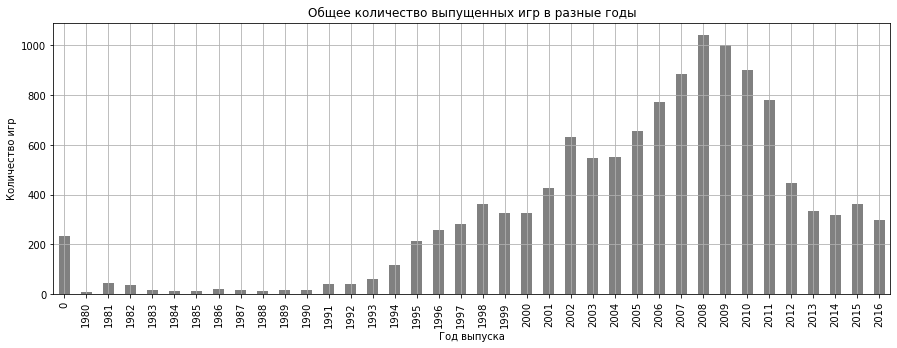

In [9]:
data.groupby('year_of_release')['name'].nunique().plot(kind = 'bar', figsize = (15,5), grid = True, color = 'gray')
plt.ylabel('Количество игр')
plt.xlabel('Год выпуска')
plt.title('Общее количество выпущенных игр в разные годы')

До 1994 года выпускалось менее 100 игр в год, таким образом можно не учитывать годы с 1980 по 1993

*Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?*

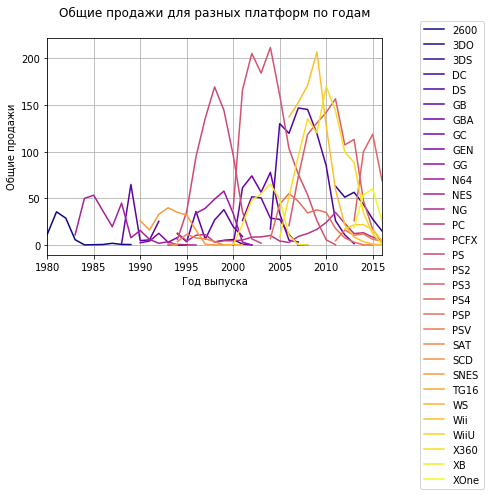

In [10]:
summary_table = data.\
    query('year_of_release != 0').\
    pivot_table(index = ['year_of_release'], columns = 'platform', values = 'total_sales', aggfunc='sum')
summary_table.plot(grid = True, cmap = 'plasma')
plt.ylabel('Общие продажи')
plt.xlabel('Год выпуска')
plt.title('Общие продажи для разных платформ по годам' + '\n')
plt.legend(bbox_to_anchor=(1.1, 1.1))

Text(0.5, 1.0, 'Суммарные продажи игр для разных платформ \n')

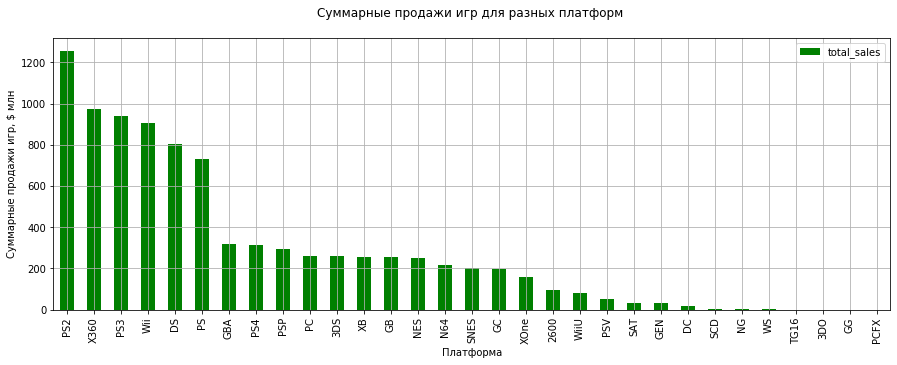

In [11]:
data.\
    groupby('platform')['total_sales'].\
    sum().\
    reset_index().\
    sort_values(by = 'total_sales', ascending = False).\
    reset_index(drop = True).\
    plot(x = 'platform', y = 'total_sales', kind = 'bar', figsize = (15, 5), grid = True, color = 'green')

plt.ylabel('Суммарные продажи игр, $ млн')
plt.xlabel('Платформа')
plt.title('Суммарные продажи игр для разных платформ \n')

In [12]:
#Создадим список наиболее популярных платформ
top_platforms = data.\
    groupby('platform')['total_sales'].\
    sum().\
    reset_index().\
    sort_values(by = 'total_sales', ascending = False).\
    head(6)['platform'].\
    tolist()

display(top_platforms)

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

платформы с наибольшими общими продажами: PS2, X360, PS3, Wii, DS, PS. Рассмотрим далее только их

Text(0.5, 1.0, 'Количество игр для разных платформ по годам')

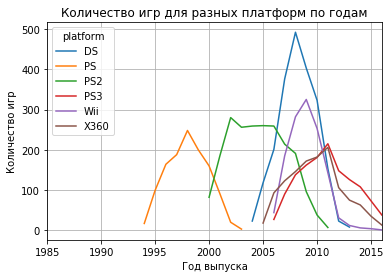

In [13]:
#распределение количество игр на разных платформах по годам
summary_table = data.\
    query('year_of_release != 0').\
    query('platform in @top_platforms').\
    pivot_table(index = ['year_of_release'], columns = 'platform', values = 'name', aggfunc='count')
summary_table.plot(grid = True)
plt.ylabel('Количество игр')
plt.xlabel('Год выпуска')
plt.title('Количество игр для разных платформ по годам')

Характерное время жизни платформы около 5 лет - ширина пика на середине высоты. В это время количество выпускаемых игр максимально. Платформы с максимальными суммарными продажами уже утратили актуальность, и количество игр для них уже стремится к нулю. Значит далее имеет смысл рассматривать период не более 5 лет, чтобы не включать в него платформы, для которых уже не выпускаются игры.

*Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.*

Чтобы построить прогноз на 2017 год возьмем данные за предшествующие 4 года (минус 5 лет от года, для которого делается прогноз)

In [14]:
#выделим данные за последние 4 года, чтобы увидеть динамику продаж на платформах
data_5_years = data.query('year_of_release > year_of_release.max() - 4')

*Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ*

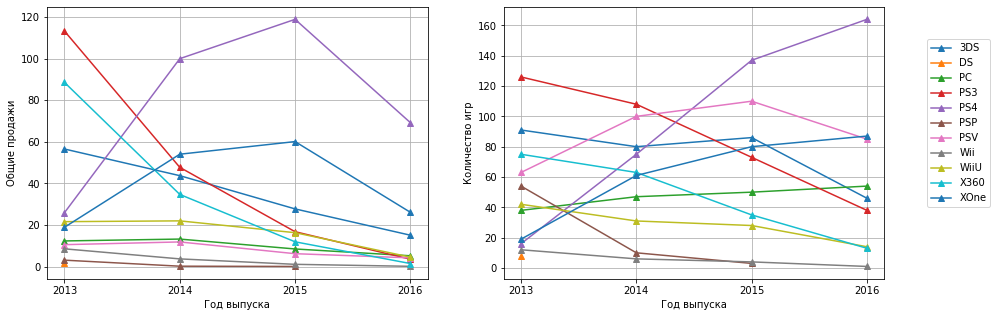

In [15]:
#распределение количество игр на разных платформах по годам
summary_5_years = data_5_years.\
    pivot_table(index = ['year_of_release'], columns = 'platform', values = ['total_sales'], aggfunc=['count','sum'])

plt.rcParams['axes.grid'] = True
plt.rcParams
fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)


ax[0].plot(summary_5_years.index, summary_5_years['sum'], marker = '^')
ax[0].xaxis.set_major_locator(plt.MaxNLocator(4))
ax[0].set_ylabel('Общие продажи')
ax[0].set_xlabel('Год выпуска')

ax[1].plot(summary_5_years.index, summary_5_years['count'], marker = '^')
ax[1].xaxis.set_major_locator(plt.MaxNLocator(4))
ax[1].set_ylabel('Количество игр')
ax[1].set_xlabel('Год выпуска')
plt.legend(summary_5_years.columns.droplevel(level=[0, 1]), bbox_to_anchor=(1.1, 0.9))
plt.show()

*Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? Опишите результат.*

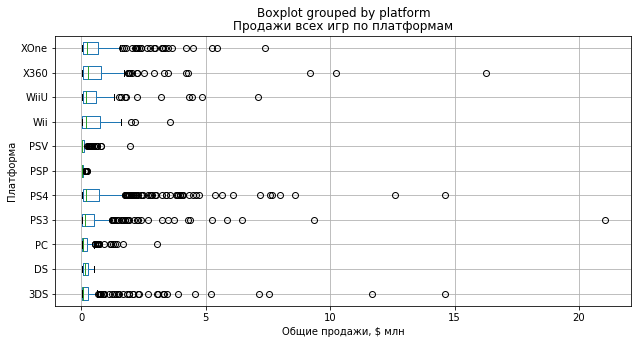

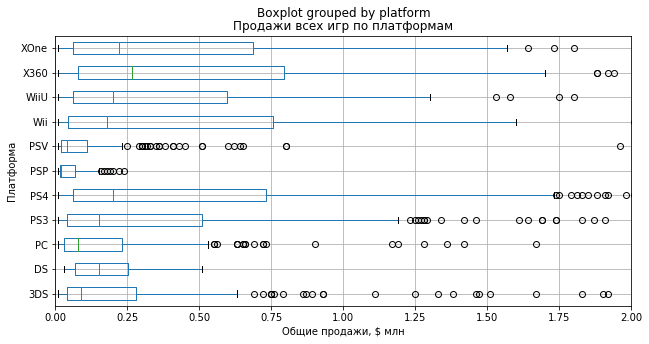

In [16]:
data_5_years.boxplot('total_sales', by = 'platform', vert = False, figsize = (10,5))
plt.xlabel('Общие продажи, $ млн')
plt.ylabel('Платформа')
plt.title('Продажи всех игр по платформам')
plt.show()

data_5_years.boxplot('total_sales', by = 'platform', vert = False, figsize = (10,5))
plt.xlabel('Общие продажи, $ млн')
plt.ylabel('Платформа')
plt.title('Продажи всех игр по платформам')
plt.xlim(0,2)
plt.show()

,mean,median,count,sum
,total_sales,total_sales,total_sales,total_sales
platform,,,,
3DS,0.472772,0.090,303,143.25
DS,0.192500,0.150,8,1.54
PC,0.208624,0.080,189,39.43
PS3,0.525884,0.150,345,181.43
PS4,0.801378,0.200,392,314.14
PSP,0.052239,0.020,67,3.50
PSV,0.092151,0.040,358,32.99
Wii,0.593913,0.180,23,13.66


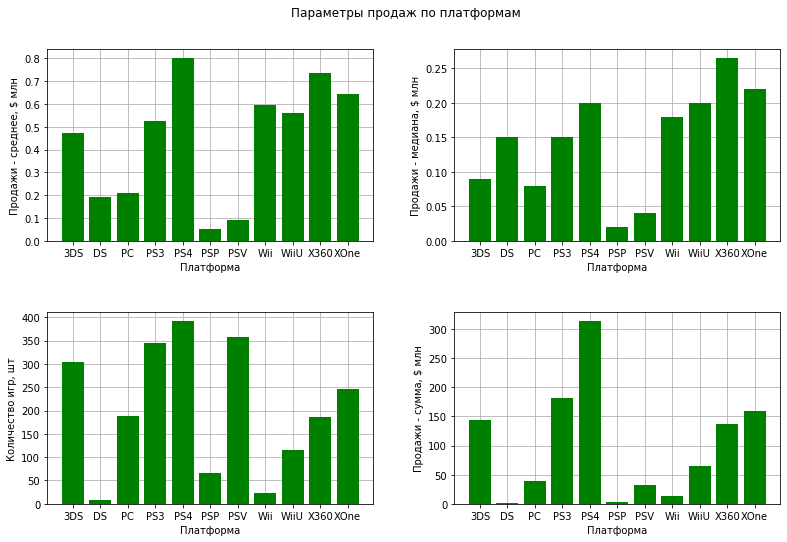

In [17]:
summary = data_5_years.pivot_table(index = 'platform', values = 'total_sales', aggfunc = ['mean','median', 'count', 'sum'])
display(summary)


ylabels = ['Продажи - среднее, $ млн','Продажи - медиана, $ млн','Количество игр, шт','Продажи - сумма, $ млн']

fig, ax = plt.subplots(2,2)
fig.set_figwidth(12)
fig.set_figheight(8)
fig.tight_layout(pad=5.0)
ax = ax.flatten()
fig.suptitle('Параметры продаж по платформам')
plt.rcParams['axes.grid'] = True
num = 0

for column in summary.columns:
    ax[num].bar(x=summary.index, height = summary[column], color = 'green')
#    ax[num].set_title(column)
    ax[num].set_ylabel(ylabels[num])
    ax[num].set_xlabel('Платформа')
    ax[num].set_axisbelow(True)
    num +=1

plt.show()

По средним продажам платформы примерно делятся на две группы: DS, PC, PSP и PSV имеют продажи минимум в три раза меньше, чем 3DS, PS3, PS4, Wii, WiiU, XOne и X360.

*Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.*

*Соотнесите выводы с продажами игр на других платформах*

In [18]:
#Выберем топ 5 платформ, по количеству отзывов пользователей и критиков
data_score = data_5_years.\
    groupby('platform', as_index = False)['critic_score', 'user_score'].\
    count().\
    sort_values(by='critic_score', ascending=False).\
    reset_index(drop=True)
display(data_score)

platforms_top_score = data_5_years.\
    groupby('platform', as_index = False)['critic_score', 'user_score'].\
    count().\
    sort_values(by='critic_score', ascending=False).\
    reset_index(drop=True).\
    head(5)['platform'].\
    tolist()
display(platforms_top_score)

,platform,critic_score,user_score
0,PS4,252,259
1,XOne,169,185
2,PC,149,156
3,PS3,121,196
4,X360,81,148
5,PSV,77,101
6,3DS,71,93
7,WiiU,70,81
8,PSP,1,2
9,DS,0,3


['PS4', 'XOne', 'PC', 'PS3', 'X360']

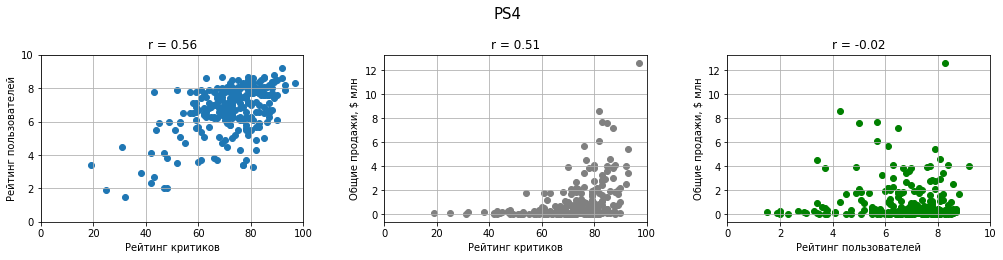

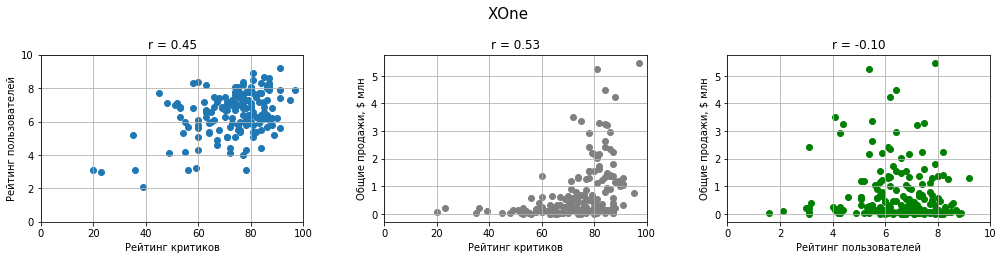

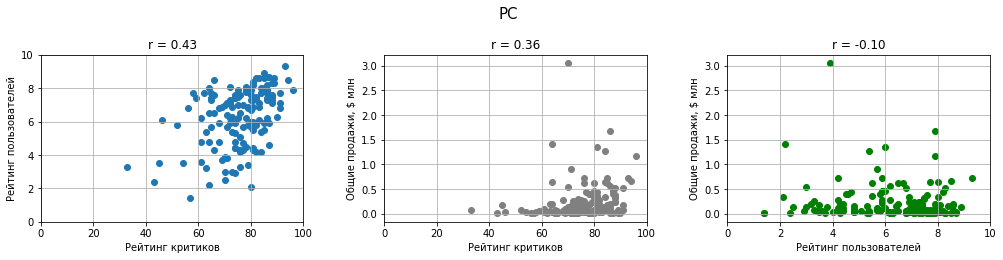

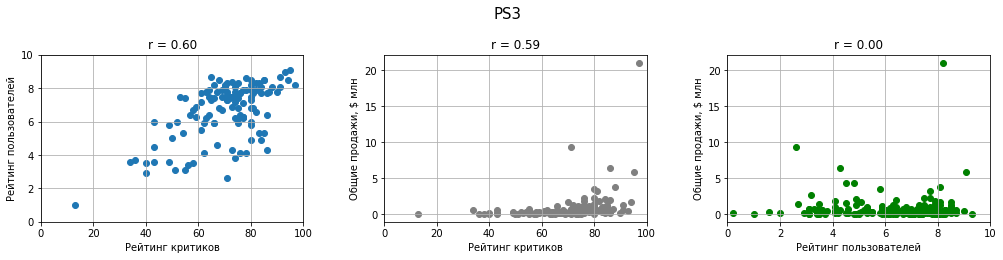

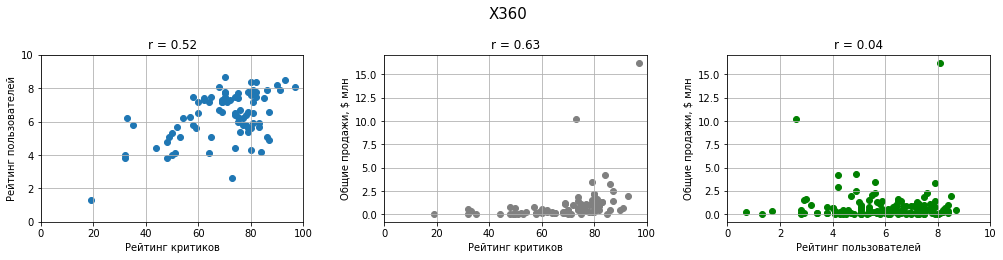

In [19]:
for item in platforms_top_score:
    data_platform = data_5_years.query('platform == @item')
    
    fig, ax = plt.subplots(1,3)
    fig.set_figwidth(15)
    fig.suptitle(item, fontsize = 15)
    fig.tight_layout(pad=5.0)
    
    ax[0].scatter(x=data_platform['critic_score'], y = data_platform['user_score'])
    ax[0].set_ylabel('Рейтинг пользователей')
    ax[0].set_xlabel('Рейтинг критиков')
    ax[0].set_xlim(0,100)
    ax[0].set_ylim(0,10)
    ax[0].set_title('r = {:.2f}'.
                    format(data_platform['critic_score'].
                           corr(data_platform['user_score'], method = 'pearson')))
    
    ax[1].scatter(x=data_platform['critic_score'], y = data_platform['total_sales'], color = 'grey')
    ax[1].set_xlabel('Рейтинг критиков')
    ax[1].set_ylabel('Общие продажи, $ млн')
    ax[1].set_xlim(0,100)
    ax[1].set_title('r = {:.2f}'.
                    format(data_platform['critic_score'].
                           corr(data_platform['total_sales'], method = 'spearman'))) # связь нелинейная, значит коээфициент корреляции Пирсона даст заниженные значения
    
    ax[2].scatter(x=data_platform['user_score'], y = data_platform['total_sales'], color = 'green')
    ax[2].set_xlabel('Рейтинг пользователей')
    ax[2].set_ylabel('Общие продажи, $ млн')
    ax[2].set_xlim(0,10)
    ax[2].set_title('r = {:.2f}'.
                    format(data_platform['user_score'].
                           corr(data_platform['total_sales'], method = 'spearman')))
    plt.show()

Продажи игр коррелируют с оценками критиков для платформ PS4, Xone, PS3  и X360 и не коррелируют с оценками пользователей. Для платформы РС корреляция оценки критиков с продажами слабая (r=0.36). 
Возможно пользователи покупают игру после ее обзора критиком, и если критики ставят высокие оценки, игру покупают чаще. Отзывы пользователей пишутся уже после продажи, поэтому их влияние ниже

*Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?*

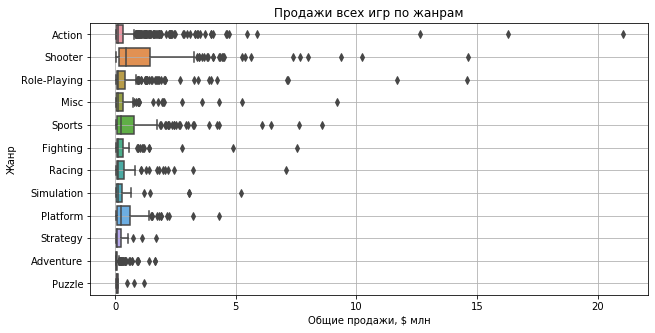

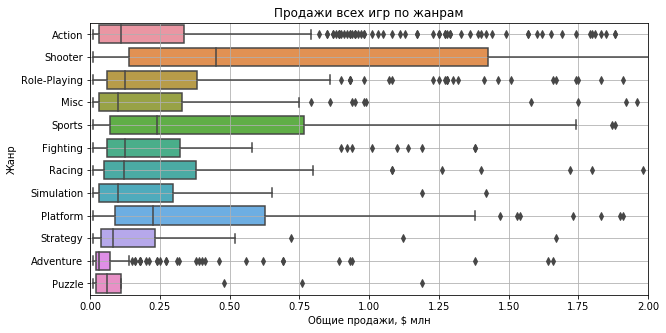

In [20]:
fig, ax = plt.subplots(figsize = (10,5))
sbn.boxplot(data = data_5_years, x = 'total_sales', y = 'genre')
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.xlabel('Общие продажи, $ млн')
plt.ylabel('Жанр')
plt.title('Продажи всех игр по жанрам')
plt.show()

fig, ax = plt.subplots(figsize = (10,5))
sbn.boxplot(data = data_5_years, x = 'total_sales', y = 'genre')
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.xlabel('Общие продажи, $ млн')
plt.ylabel('Жанр')
plt.title('Продажи всех игр по жанрам')
plt.xlim(0,2)
plt.show()

,mean,median,count,sum
,total_sales,total_sales,total_sales,total_sales
genre,,,,
Action,0.420196,0.110,766,321.87
Adventure,0.096490,0.030,245,23.64
Fighting,0.441375,0.125,80,35.31
Misc,0.405290,0.100,155,62.82
Platform,0.576081,0.225,74,42.63
Puzzle,0.186471,0.060,17,3.17
Racing,0.469294,0.120,85,39.89
Role-Playing,0.499623,0.125,292,145.89


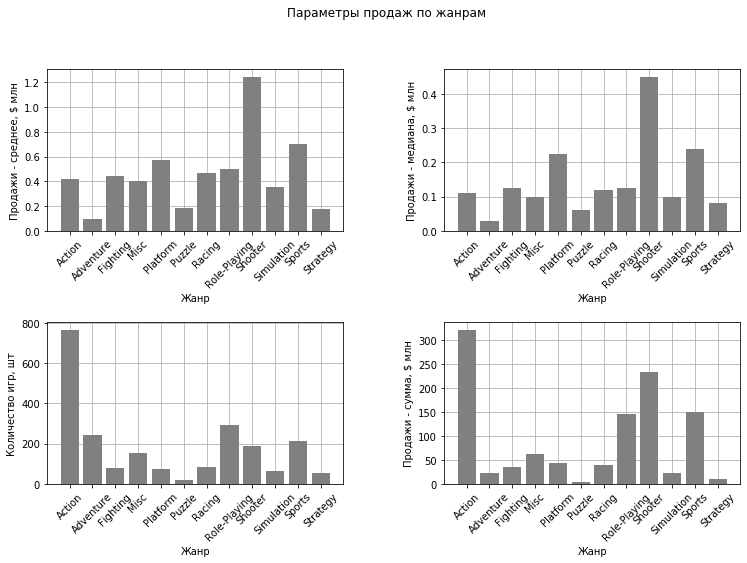

In [21]:
summary = data_5_years.pivot_table(index = 'genre', 
                                   values = 'total_sales', 
                                   aggfunc = ['mean','median', 'count', 'sum'])
display(summary)

ylabels = ['Продажи - среднее, $ млн','Продажи - медиана, $ млн','Количество игр, шт','Продажи - сумма, $ млн']

fig, ax = plt.subplots(2,2)
fig.set_figwidth(12)
fig.set_figheight(8)
fig.tight_layout(pad=7.0)
ax = ax.flatten()
fig.suptitle('Параметры продаж по жанрам')
plt.rcParams['axes.grid'] = True
num = 0

for column in summary.columns:
    ax[num].bar(x=summary.index, height = summary[column], color = 'grey')
    ax[num].set_ylabel(ylabels[num])
    ax[num].set_xlabel('Жанр')
    ax[num].set_axisbelow(True)
    ax[num].tick_params(axis = 'x', labelrotation = 45)
    num +=1

plt.show()

Среди жанров с большим отрывом по средним продажам лидирует Shooter, за ним следуют Sports  и Platform. Продажи остальных жанров минимум в два раза ниже. Наименее популярными жарнами являются Adventure и Puzzle. По суммарным продажам лидирует Action из-за самого большого количества игр в этом жанре


### Выводы

* Массовый выпуск игр начался после 1993 года с максимумом в 2008 году
* Характерное время активной жизни игровых платформ составляет около 5 лет - в этот период количество игр, выпускаемых для платформы, максимально
* Наиболее перспективными платформами в 2016 года являются PS4, PC, XOne. Количество выпускаемых игр и продажи за последние 4 года растут, значит они находятся в активной фазе своего жизненного цикла
* PS4 является лидером продаж
* PS3, X360 и 3DS уже находятся в фазе спада популярности, хотя они входят в список платформ с самыми высокими суммарными продажами
* Продажи игр коррелируют с оценками критиков и не коррелируют с оценками пользователей
* Наиболее прибыльными жанрами игр являются Action, Shooter, Sports и Role-Playing. При этом суммарные продаж жанра Action самые высокие за счет большого количества выпускаемых игр, а продажи остальных прибыльных жанров - за счет высокого среднего уровня продаж игр.
* Жанр Adventure является наименее прибыльным, хотя количество выпускаемых игр одно из самых высоких

## Шаг 4. Портрет пользователя каждого региона <a name="step4"></a>

*Определите для пользователя каждого региона (NA, EU, JP):*
- *Самые популярные платформы (топ-5). Опишите различия в долях продаж.*
- *Самые популярные жанры (топ-5). Поясните разницу.*
- *Влияет ли рейтинг ESRB на продажи в отдельном регионе?*

'Северная Америка'

,platform,total_sales,percentage
0,PS4,108.74,24.842933
1,XOne,93.12,21.274360
2,X360,81.66,18.656188
3,PS3,63.50,14.507322
4,3DS,38.20,8.727239


'Европа'

,platform,total_sales,percentage
0,PS4,141.09,35.971241
1,PS3,67.81,17.288326
2,XOne,51.59,13.152997
3,X360,42.52,10.840578
4,3DS,30.96,7.893328


'Япония'

,platform,total_sales,percentage
0,3DS,67.81,48.167353
1,PS3,23.35,16.586163
2,PSV,18.59,13.205001
3,PS4,15.96,11.336838
4,WiiU,10.88,7.728371


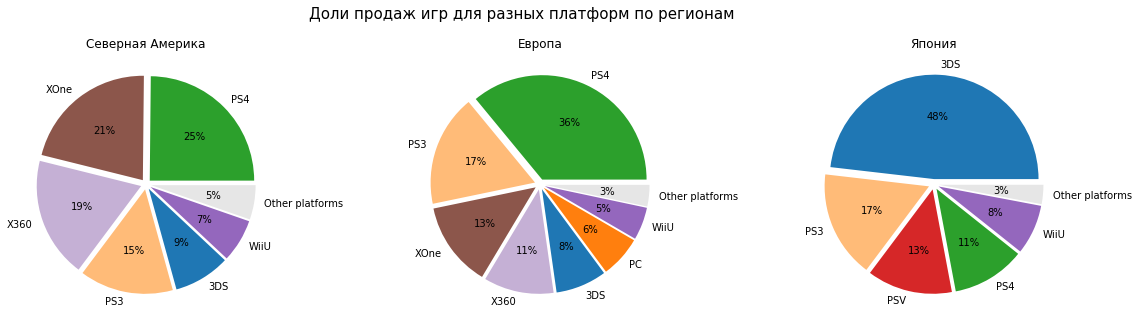

In [22]:
#Список названий графиков
titles = ['Северная Америка', 'Европа', 'Япония']
num=0
fig, ax = plt.subplots(1, 3, figsize = (20,5))
fig.suptitle('Доли продаж игр для разных платформ по регионам' + '\n', fontsize = 15)

#Словарь для цветов графика
cdict = dict(zip(np.unique(data_5_years['platform'].values), plt.cm.tab20.colors))
cdict.update({'Other platforms' :(0.9,0.9,0.9) })

for column in ['na_sales', 'eu_sales', 'jp_sales']:

    # расчитаем продажи и процент от общих для каждой платформы
    summary = data_5_years.\
    pivot_table(index = 'platform', values = column, aggfunc = ['sum',lambda x : 100 * x.sum() / data_5_years[column].sum()]).\
    reset_index()
   
    # изменим название колонок
    summary.columns = ['platform', 'total_sales', 'percentage']
    
    # объединим продажи с минимальными продажами (<3% от общих) в одну группу
    summary.loc[summary['percentage'] < 3, 'platform'] = 'Other platforms'
    
    summary = summary.\
        groupby('platform', as_index = False).\
        agg('sum').\
        sort_values(by='total_sales', ascending = False).\
        reset_index(drop=True)
    
    #построим круговую диаграмму и таблицу
    summary['explode'] = 0.05
    
    ax[num].pie(summary['total_sales'], labels = summary['platform'], autopct='%.0f%%', explode = summary['explode']
               ,colors=[cdict[v] for v in summary['platform']])
    ax[num].set_title(titles[num])
    
    plt.subplots_adjust(top=0.85)
    
    summary.name = titles[num]
    display(summary.name)
    display(summary[['platform', 'total_sales', 'percentage']].head(5))
    
    num += 1

plt.show()

Состав пятерки самых популярных платформ одинаковый в Европе и Северной Америке. На первом месте по продажам PS4. В америке доля PS и XOne примерно одинакова (25% и 21% соответственно), в Европе продажи игр на PS4 составляют 36%, XOne всего 13%. При этом в европе PS3 популярнее как XOne, так и X360. В Японии список популярных платформ возглавляет 3DS (48%), которая в Европе и Северной Америке находится на 5 месте. XOne и X360, популярные в Европе и Америке, в пятерку не входят. Все популярные в Японии платформы производятся японскими компаниями, а консоли от Microsoft там не имеют успеха.

'Северная Америка'

,genre,total_sales,percentage
0,Action,126.05,28.797606
1,Shooter,109.74,25.071394
2,Sports,65.27,14.911700
3,Role-Playing,46.40,10.600626
4,Misc,27.49,6.280414


'Европа'

,genre,total_sales,percentage
0,Action,118.13,30.117533
1,Shooter,87.86,22.400122
2,Sports,60.52,15.429722
3,Role-Playing,36.97,9.425592
4,Racing,20.19,5.147490


'Япония'

,genre,total_sales,percentage
0,Role-Playing,51.04,36.255150
1,Action,40.49,28.761188
2,Misc,9.20,6.535019
3,Fighting,7.65,5.434011
4,Shooter,6.61,4.695269


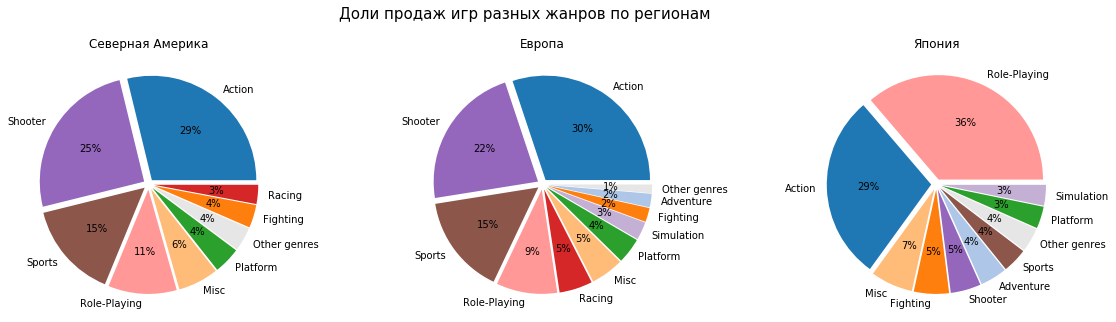

In [23]:
titles = ['Северная Америка', 'Европа', 'Япония']
num=0
fig, ax = plt.subplots(1, 3, figsize = (20,5))
fig.suptitle('Доли продаж игр разных жанров по регионам' + '\n', fontsize = 15)

#Словарь для цветов графика
cdict = dict(zip(np.unique(data_5_years['genre'].values), plt.cm.tab20.colors))
cdict.update({'Other genres' :(0.9, 0.9, 0.9) })


for column in ['na_sales', 'eu_sales', 'jp_sales']:

    # расчитаем продажи и процент от общих для каждой платформы
    summary = data_5_years.\
    pivot_table(index = 'genre',
                values = column, 
                aggfunc = ['sum',lambda x : 100 * x.sum() / data_5_years[column].sum()]).\
    reset_index()
   
    # изменим название колонок
    summary.columns = ['genre', 'total_sales', 'percentage']
    
    # объединим продажи с минимальными продажами (<= 2% от общих) в одну группу
    summary.loc[summary['percentage'] <= 2, 'genre'] = 'Other genres'
    
    summary = summary.\
        groupby('genre', as_index = False).\
        agg('sum').\
        sort_values(by='total_sales', ascending = False).\
        reset_index(drop=True)
    
    #построим круговую диаграмму и таблицу
    summary['explode'] = 0.05
    
    ax[num].pie(summary['total_sales'], labels = summary['genre'], autopct='%.0f%%', explode = summary['explode']
               ,colors=[cdict[v] for v in summary['genre']])
    ax[num].set_title(titles[num])
    
    summary.name = titles[num]
    display(summary.name)
    display(summary[['genre', 'total_sales', 'percentage']].head(5))
    
    num += 1
    
plt.subplots_adjust(top=0.85)
plt.show()
    

Пятерка самых популярных жарнов игр практически одинакова в Европе и Северной Америке. Action, Shooter и Sports являются самыми популярными и имеют почти одинаковые доли продаж (30%, 25%, 15% соответственно). Role Playing имеет долю около 10% и идет на 4 месте. В японии же этот жанр является наиболее популярным, и доля его продаж составляет 36%. Action, наиболее популярный в Европе и Северной Америке, имеет около 30% продаж. Доля остальных стилей не превышает 7%.

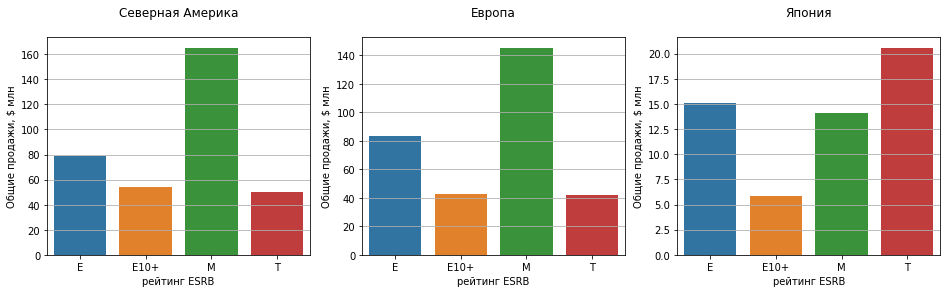

In [24]:
titles = ['Северная Америка', 'Европа', 'Япония']
fig, ax = plt.subplots(1,3, figsize = (16,4))
num=0

for column in ['na_sales', 'eu_sales', 'jp_sales']:
    
    summary = data_5_years.\
    pivot_table(index = 'rating', values = column, aggfunc ='sum')
    
    sbn.barplot(data = summary, x = summary.index, y = column, ax = ax[num]).set_title(titles[num] + '\n')
    ax[num].set_ylabel('Общие продажи, $ млн')
    ax[num].set_xlabel('рейтинг ESRB')
    num +=1

plt.show()

В Европе и Северной Америке лучше всего продаются игры категории М (возраст 17+), в японии - Т (возраст 13+). Игры категории Е10+ во всех рассмотренных регионах продаются плохо

### Вывод

Пользователей в различных регионах можно описать следующим образом(платформы и игры, составляюшие как минимум половину продаж каждого региона):

Северная Америка:
* Игровая платформа PS4, XOne или X360, игры жанра Action и Shooter, рейтинг игр М по версии ESRB

Европа
* Игровая платформа PS4 или PS3, игры жанра Action и Shooter, рейтинг игр М по версии ESRB

Япония
* Игровая платформа 3DS или PS3, игры жанра Role Playing и Action, рейтинг игр T по версии ESRB

Пользователи из Северной Америки и Европы демонстрируют схожие предпочтения и значительно отличаются от японских.

## Шаг 5. Проверка гипотез  <a name="step5"></a>

 - *Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;*
 - *Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.*

In [25]:
#функция для проверки нормальности распределения с использованием критерия Шапиро-Уилка, который подходит для небольших выборок
def normality_test(column, alpha):
    result = st.shapiro(column)
    print('p=', result[1])
    if result[1] > alpha:
        print('Выборка получена из нормального распределения') # нулевая гипотеза - выборка получена из нормального распределения
    else:
        print('Распределение отличается от нормального') # отвергаем нулевую гипотезу

In [26]:
# функция для проверки гипотезы о равенстве двух средних для независимых выборок, имеющих нормальное распределение
def ttest_independent(column1, column2, alpha):
    result = st.ttest_ind(column1, column2)
    print(column1.name, column1.mean())
    print(column2.name, column2.mean())
    print('p =',result.pvalue)
    if result.pvalue > alpha:
        print('Различие средних статистически недостоверно') # нулевая гипотеза - средние двух выборок равны
    else:
        print('Различие средних статистически достоверно') # отвергаем нулевую гипотезу о равенстве средних двух выборок

In [27]:
# функция для проверки гипотезы о равенстве двух средних для независимых выборок, если распределение отличается от нормального
# (критерий Уилкоксона)
def ranksum_independent(column1, column2, alpha):
    result = st.ranksums(column1, column2)
    print('Средние значения:', '\n')
    print(column1.name, '{:.2f}'.format(column1.mean()))
    print(column2.name,'{:.2f}'.format(column2.mean()))
    print('\n','p =',result.pvalue, '\n')
    if result.pvalue > alpha:
        print('Различие средних статистически недостоверно') # нулевая гипотеза - средние двух выборок равны
    else:
        print('Различие средних статистически достоверно') # отвергаем нулевую гипотезу о равенстве средних двух выборок

In [28]:
#выделяем группы для проверки гипотез
score_xone = data_5_years.query('platform == "XOne"')['user_score'].dropna()
score_xone.name = 'Оценки пользователей для платформы XOne'
score_pc = data_5_years.query('platform == "PC"')['user_score'].dropna()
score_pc.name = 'Оценки пользователей для платформы PC'
score_action = data_5_years.query('genre == "Action"')['user_score'].dropna()
score_action.name = 'Оценки пользователей для жанра Action'
score_sports = data_5_years.query('genre == "Sports"')['user_score'].dropna()
score_sports.name = 'Оценки пользователей для жанра Sports'

Text(0, 0.5, 'Оценка')

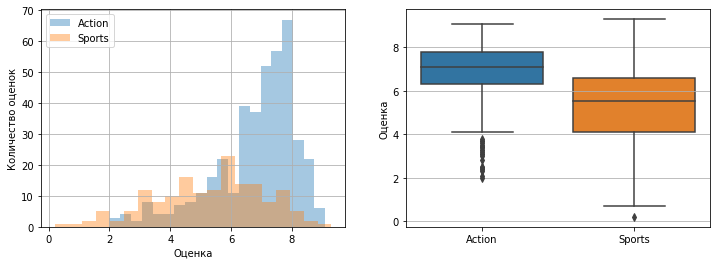

In [29]:
score_genres = pd.concat([score_action, score_sports], axis = 1)
score_genres.columns = ['Action', 'Sports']

fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)

sbn.distplot(score_action, kde=False, bins=20, label = 'Action', ax=ax[0])
sbn.distplot(score_sports, kde=False, bins=20, label = 'Sports', ax=ax[0])
ax[0].legend()
ax[0].set_ylabel ('Количество оценок')
ax[0].set_xlabel('Оценка')

sbn.boxplot(data = score_genres, ax = ax[1])
ax[1].set_ylabel('Оценка')

Text(0, 0.5, 'Оценка')

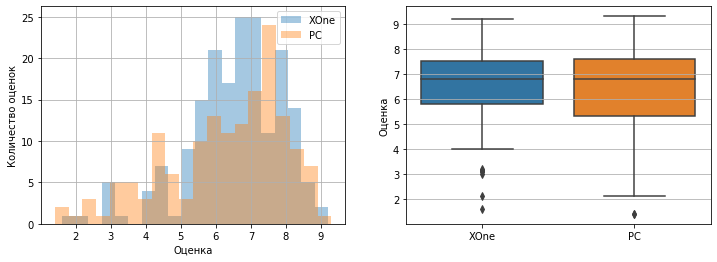

In [30]:
score_platforms = pd.concat([score_xone, score_pc], axis = 1)
score_platforms.columns = ['XOne', 'PC']

fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)

sbn.distplot(score_xone, kde=False, bins=20, label = 'XOne', ax=ax[0])
sbn.distplot(score_pc, kde=False, bins=20, label = 'PC', ax=ax[0])
ax[0].legend()
ax[0].set_ylabel ('Количество оценок')
ax[0].set_xlabel('Оценка')

sbn.boxplot(data = score_platforms, ax = ax[1])
ax[1].set_ylabel('Оценка')

In [31]:
#проверяем, нормальное ли распределение, чтобы выбрать тест для проверки гипотез
for column in (score_xone, score_pc, score_action, score_sports):
    print(column.name)
    normality_test(column, 0.05)
    print()

Оценки пользователей для платформы XOne
p= 1.2756141586578451e-05
Распределение отличается от нормального

Оценки пользователей для платформы PC
p= 4.097982127859723e-06
Распределение отличается от нормального

Оценки пользователей для жанра Action
p= 9.772924267401452e-16
Распределение отличается от нормального

Оценки пользователей для жанра Sports
p= 0.08689885586500168
Выборка получена из нормального распределения



Так как 3 из 4 распределений достоверно отличаются от нормального, то следует использовать непараметрический тест для сравнения средних

In [32]:
ranksum_independent(score_xone, score_pc, 0.05)

Средние значения: 

Оценки пользователей для платформы XOne 6.52
Оценки пользователей для платформы PC 6.28

 p = 0.5511946208634454 

Различие средних статистически недостоверно


In [33]:
ranksum_independent(score_sports, score_action, 0.05)

Средние значения: 

Оценки пользователей для жанра Sports 5.29
Оценки пользователей для жанра Action 6.81

 p = 9.116254341547301e-22 

Различие средних статистически достоверно


### Вывод:

* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые (средние значения статистически достоверно не различаются, p > 0.05)
* Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные (средние значения статистически достоверно отличаются, p < 0.05)

## Общий вывод <a name="step6"></a>


* Характерное время активной жизни игровых платформ составляет около 5 лет - в этот период количество игр, выпускаемых для платформы, максимально


* Наиболее перспективными платформами в 2016 года являются PS4, PC, XOne. Количество выпускаемых игр и продажи за последние 4 года растут, значит они находятся в активной фазе своего жизненного цикла


* Игры на PS4 наиболее популярны


* Продажи игр коррелируют с оценками критиков для платформ PS4 и Xone (r = 0.51 и 0.53 соответственно) и не коррелируют с оценками пользователей. Для платформы РС корреляция оценки критиков с продажами слабая (r=0.36). Возможно пользователи покупают игру после ее обзора критиком, и если критики ставят высокие оценки, игру покупают чаще. Отзывы пользователей пишутся уже после продажи, поэтому их влияние ниже


* Наиболее прибыльными жанрами игр являются Action, Shooter, Sports и Role-Playing. При этом суммарные продаж жанра Action самые высокие за счет большого количества выпускаемых игр, а продажи остальных прибыльных жанров - за счет высокого среднего уровня продаж игр. Жанр Adventure является наименее прибыльным, хотя количество выпускаемых игр одно из самых высоких


* Наиболее популярными видами игр в разных регионах являются:

    
    - Северная Америка: игровая платформа PS4, XOne или X360, игры жанра Action и Shooter, рейтинг игр М по версии ESRB

    - Европа: игровая платформа PS4 или PS3, игры жанра Action и Shooter, рейтинг игр М по версии ESRB

    - Япония: игровая платформа 3DS или PS3, игры жанра Role Playing и Action, рейтинг игр T по версии ESRB
    

* Пользователи из Северной Америки и Европы демонстрируют схожие предпочтения и значительно отличаются от японских


* Платформа PS3 в ближайшие годы уступит место PS4, X360 будет заменяться на XOne


* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые (p > 0.05)


* Средние пользовательские рейтинги жанров Action и Sports разные (p < 0.05)

